In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, activations, initializers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
# Read dow jones data 
SP500 = pd.read_csv('DJA.csv')
print(SP500.shape)
SP500.head()

# NLP = pd.read_csv("/Users/gaojinglun/Desktop/NLP_vaderindex.csv")
# print(NLP.shape)
# NLP.head()

start = np.where(SP500['Date'] == '2008-08-08')[0][0]
end = np.where(SP500['Date'] == '2016-07-01')[0][0]
DJA = SP500.iloc[np.arange(start, (end + 1))]
DJA['sentiment'] = NLP['sentiment'].values
DJA.head()

DJA["stoch"] = ta.momentum.StochasticOscillator(SP500["High"],SP500["Low"],SP500["Close"],window=5).stoch()
DJA["EMA"] =  ta.trend.EMAIndicator(SP500["Close"],window = 5).ema_indicator()
DJA["MACD"] = ta.trend.MACD(SP500["Close"],window_slow = 10, window_fast = 5).macd()
DJA["SMA"] = ta.trend.SMAIndicator(SP500["Close"],window = 5).sma_indicator()
DJA["WMA"] = ta.trend.WMAIndicator(SP500["Close"],window = 5).wma()
DJA["ROC"] = ta.momentum.ROCIndicator(SP500["Close"],window = 5).roc()
DJA["williams_r"] = ta.momentum.WilliamsRIndicator(SP500["High"],SP500["Low"],SP500["Close"]).williams_r()
DJA["ADI"] = ta.volume.AccDistIndexIndicator(SP500["High"],SP500["Low"],SP500["Close"],SP500["Volume"]).acc_dist_index()
DJA["MFI"] = ta.volume.MFIIndicator(SP500["High"],SP500["Low"],SP500["Close"],SP500["Volume"],window = 5).money_flow_index()
DJA["ATR"] = ta.volatility.AverageTrueRange(SP500["High"],SP500["Low"],SP500["Close"],window = 5).average_true_range()

# # Read interest rate data
# DGS1 = pd.read_csv('/Users/gaojinglun/Desktop/DGS1MO.csv')
# DGS3 = pd.read_csv('/Users/gaojinglun/Desktop/DGS6MO.csv')
# DGS6 = pd.read_csv('/Users/gaojinglun/Desktop/DGS3MO.csv')
# DGS12 = pd.read_csv('/Users/gaojinglun/Desktop/DGS1.csv')

# def get_interest_rate(data, col):
#     date = SP500['Date'].values
#     result = np.zeros_like(date)
#     for i in range(len(date)):
#         for j in range(i, data.shape[0]):
#             if date[i] == data['DATE'][j]:
#                 result[i] = data[col][j]
#                 break
#     assert (np.sum(result) == 0) == 0, '0 interest rate'
#     return result

# def process(x):
#     result = np.zeros_like(x)
#     for i in range(len(x)):
#         if x[i] == '.':
#             result[i] = np.nan
#         else:
#             result[i] = float(x[i])
#     return result


# DJA['DGS1MO'] = process(get_interest_rate(DGS1, 'DGS1MO')).astype('float')[np.arange(start, (end + 1))]
# DJA['DGS6MO'] = process(get_interest_rate(DGS3, 'DGS6MO')).astype('float')[np.arange(start, (end + 1))]
# DJA['DGS3MO'] = process(get_interest_rate(DGS6, 'DGS3MO')).astype('float')[np.arange(start, (end + 1))]
# DJA['DGS1'] = process(get_interest_rate(DGS12, 'DGS1')).astype('float')[np.arange(start, (end + 1))]

# DJA = DJA.dropna()

# DJA.head()

# DJA.to_csv('/Users/gaojinglun/Desktop/data.csv')

In [3]:
DJA = pd.read_csv('data.csv')
DJA = DJA.drop(['Unnamed: 0'], axis = 1)
DJA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment,stoch,EMA,...,WMA,ROC,williams_r,ADI,MFI,ATR,DGS1MO,DGS6MO,DGS3MO,DGS1
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,11734.320312,212830000,-0.9982,95.238069,11567.876040,...,11592.081380,3.602229,-4.038821,6.788868e+09,61.436462,247.593115,1.63,1.95,1.70,2.19
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,-0.9858,85.413512,11639.367230,...,11671.415234,4.415035,-11.423581,6.809961e+09,78.118740,236.390508,1.77,2.05,1.87,2.27
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,11642.469727,173590000,-0.9715,53.109049,11640.401395,...,11670.909180,0.229862,-30.275814,6.714992e+09,59.026974,225.278422,1.73,2.05,1.86,2.18
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,11532.959961,182550000,-0.9809,30.250241,11604.587584,...,11632.119857,-1.056191,-45.034931,6.693544e+09,40.608187,218.048714,1.80,2.00,1.85,2.19
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,11615.929688,159790000,-0.9882,47.569144,11608.368285,...,11629.194466,1.613971,-33.852733,6.731006e+09,61.071556,227.917096,1.76,2.00,1.89,2.14


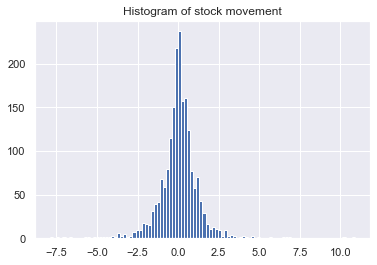

In [4]:

movement_percentage = ((DJA['Adj Close'].shift(-1) / DJA['Adj Close']) -1) * 100
plt.hist(movement_percentage, bins = 100)
plt.title("Histogram of stock movement")
plt.show()

In [5]:
threshold = 0
neutral_idx = np.abs(movement_percentage) < threshold
np.sum(neutral_idx), DJA.shape[0]

(0, 1973)

In [6]:
label = np.zeros(DJA.shape[0])
label[neutral_idx] = 0
label[movement_percentage >= threshold] = 1
label[movement_percentage <= -threshold] = -1
np.sum(label == 0)

1

In [7]:
DJA['Stock Movement'] = label
DJA['Previous Stock Movement'] = DJA['Stock Movement'].shift(1)
DJA = DJA.dropna()
DJA.index.values

array([   1,    2,    3, ..., 1970, 1971, 1972])

In [8]:
new_data = DJA.iloc[np.arange(0, DJA.shape[0] - 1)]
new_data.shape

(1971, 24)

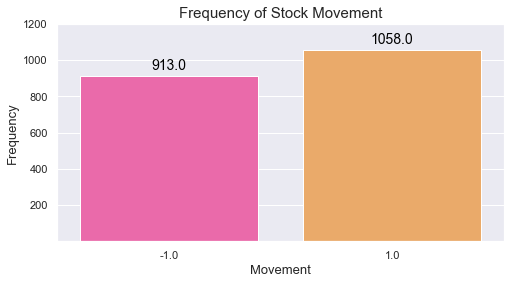

In [10]:
# bar plot of the Stock Movement's value counts
value_counts = new_data['Stock Movement'].value_counts()
class_counts = pd.DataFrame({'Class': list(value_counts.index), 'value_count': value_counts})

plt.figure(figsize = (8,4))
g = sns.barplot(x = 'Class', y = 'value_count', data = class_counts, capsize = 0.3, palette = 'spring')
g.set_title("Frequency of Stock Movement", fontsize = 15)
g.set_xlabel("Movement", fontsize = 13)
g.set_ylabel("Frequency", fontsize = 13)
g.set_yticks([200, 400, 600, 800, 1000, 1200])
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha = 'center', va = 'center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

In [11]:
X = new_data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Stock Movement', 'Date'], axis = 1)

In [12]:
# split in a stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X, new_data['Stock Movement'], test_size = 0.25, 
                                                    stratify = new_data['Stock Movement'], random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1478, 16), (493, 16), (1478,), (493,))

In [13]:
X_train.head()

,sentiment,stoch,EMA,MACD,SMA,WMA,ROC,williams_r,ADI,MFI,ATR,DGS1MO,DGS6MO,DGS3MO,DGS1,Previous Stock Movement
187,-0.9779,26.473353,8436.507487,88.082174,8465.240039,8470.480599,-0.094588,-21.546239,6.814898e+09,59.671099,167.991018,0.16,0.30,0.19,0.53,-1.0
240,-0.9943,95.229365,9006.538345,148.736180,9013.648047,9053.455990,2.942529,-1.437027,8.231974e+09,100.000000,125.129418,0.15,0.27,0.19,0.49,1.0
304,-0.9979,15.704592,9934.327902,-5.134759,9950.595898,9927.413867,-1.586524,-60.628554,1.031988e+10,18.007084,150.880182,0.05,0.17,0.08,0.39,1.0
1495,-0.9913,9.752915,16586.000259,-133.984865,16587.155859,16527.435937,-2.853805,-92.337586,3.145682e+10,18.197341,168.375618,0.03,0.05,0.03,0.12,-1.0
1416,-0.9854,2.592949,16215.115085,-70.411348,16227.231836,16192.287826,-2.351598,-98.145466,2.980641e+10,17.133754,177.097609,0.04,0.06,0.04,0.09,-1.0


In [14]:
scalerX = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train), columns = X.columns.values) 
X_test = pd.DataFrame(scalerX.transform(X_test), columns = X.columns.values) 

In [15]:
# fit four basic classifier models
basic_classifier = ['logreg', 'Knn', 'decision tree', 'SVC']
estimator = [LogisticRegression(random_state = 123),
             KNeighborsClassifier(),
             DecisionTreeClassifier(random_state = 123),
             SVC(random_state = 123)]
for i in range(4):
    cv_score = cross_val_score(estimator[i], X_train, y_train, cv = 3)
    print('The accuracy score of 3-fold cross validation for {} is {} +/- {}'.format(basic_classifier[i],
                                                                                   np.round(np.mean(cv_score), 3),
                                                                                   np.round(np.std(cv_score), 3)))
    clf = estimator[i]
    clf.fit(X_train, y_train)
    print('The test accuracy score for {} is {}'.format(basic_classifier[i],
                                                         np.round(clf.score(X_test, y_test), 3)))
    print('----------------------------------------------------------------------')   

The accuracy score of 3-fold cross validation for logreg is 0.528 +/- 0.013
The test accuracy score for logreg is 0.527
----------------------------------------------------------------------
The accuracy score of 3-fold cross validation for Knn is 0.514 +/- 0.009
The test accuracy score for Knn is 0.485
----------------------------------------------------------------------
The accuracy score of 3-fold cross validation for decision tree is 0.539 +/- 0.017
The test accuracy score for decision tree is 0.519
----------------------------------------------------------------------
The accuracy score of 3-fold cross validation for SVC is 0.54 +/- 0.005
The test accuracy score for SVC is 0.533
----------------------------------------------------------------------


### Logistics Reg

In [16]:
# Hyperparameters tuning for logistic regression 
# Try four different penalties for logiticregression 'l1’, ‘l2’, ‘elasticnet’, and ‘none
logit = LogisticRegression(random_state = 123)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver = solvers, penalty = penalty, C = c_values)
grid_search = GridSearchCV(estimator = logit, param_grid = grid, n_jobs = -1,
                           cv = 3, scoring = 'accuracy', error_score = 0)
logit_cv = grid_search.fit(X_train, y_train)

In [17]:
print('The best training accuracy score using cv is {}'.format(np.round(logit_cv.best_score_, 4)))

The best training accuracy score using cv is 0.5433


In [18]:
print('The best parameters using cv is {}'.format(logit_cv.best_params_))

The best parameters using cv is {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, logit_cv.best_estimator_.predict(X_test))

array([[ 39, 189],
       [ 39, 226]])

### SVM

In [19]:
# Using grid search cross validation to select the best alpha
SVM_para = {'kernel':['linear', 'poly', 'rbf'], 
            'C':[0.1, 0.2, 0.5, 1, 2, 5, 10],
            'class_weight':['balanced', None]}
SVM = SVC()
SVM_cv = GridSearchCV(SVM, SVM_para, scoring = 'accuracy', cv = 3, n_jobs = -1)
SVM_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1, 2, 5, 10],
                         'class_weight': ['balanced', None],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [20]:
print('The best training accuracy score using cv is {}'.format(np.round(SVM_cv.best_score_, 4)))

The best training accuracy score using cv is 0.5487


In [21]:
print('The best parameters using cv is {}'.format(SVM_cv.best_params_))

The best parameters using cv is {'C': 0.5, 'class_weight': None, 'kernel': 'poly'}


### Random Forest 

In [26]:
single_tree = DecisionTreeClassifier(random_state = 123).fit(X_train, y_train)
print("The max depth for a single decision tree is", single_tree.max_features_)

The max depth for a single decision tree is 16


In [27]:
# Hyperparameters tuning for RF
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 123)
rf = RandomForestClassifier(random_state = 123)
ne = [100, 300, 500]
depth = np.arange(10, 16, 2)
split = [2, 3, 4]
leaf = [1, 3, 5]
feature = ["auto", "log2", 'None']

# define grid search
grid = dict(n_estimators = ne, max_depth = depth, min_samples_split = split, 
            min_samples_leaf = leaf, max_features = feature)

grid_search = GridSearchCV(estimator = rf, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = skf, 
                           scoring = 'accuracy', 
                           error_score = 0)
rf_cv = grid_search.fit(X_train, y_train)

In [28]:
rf = rf_cv.best_estimator_
rf_test = np.round(rf.score(X_test, y_test), 3)
print('The test accuracy score is', rf_test)

The test accuracy score is 0.521


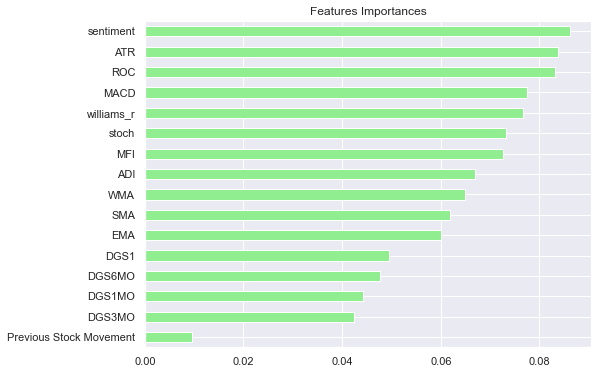

In [29]:
plt.figure(figsize = (8,6))

# Create a pd.Series of features importances
importances = pd.Series(data = rf.feature_importances_,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind = 'barh', color = 'lightgreen')
plt.title('Features Importances')
plt.show()


### Gradient Boosting Tree

In [ ]:
# Hyperparameters tuning for RF
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 123)
rf = GradientBoostingClassifier(random_state = 123)
ne = [100, 300, 500]
depth = np.arange(10, 16, 2)
split = [2, 3, 4]
leaf = [1, 3, 5]
feature = ["auto", "log2", 'None']

# define grid search
grid = dict(n_estimators = ne, max_depth = depth, min_samples_split = split, 
            min_samples_leaf = leaf, max_features = feature)

grid_search = GridSearchCV(estimator = rf, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = skf, 
                           scoring = 'accuracy', 
                           error_score = 0)
rf_cv = grid_search.fit(X_train, y_train)

In [ ]:
rf = rf_cv.best_estimator_
rf_test = np.round(rf.score(X_test, y_test), 3)
print('The test accuracy score is', rf_test)

In [ ]:
plt.figure(figsize = (8,6))

# Create a pd.Series of features importances
importances = pd.Series(data = rf.feature_importances_,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind = 'barh', color = 'lightgreen')
plt.title('Features Importances')
plt.show()


### ANN

In [24]:
X_train_new = X_train.astype('float32')
X_test_new = X_test.astype('float32')
y_train_new = to_categorical(y_train, 3)
y_test_new = to_categorical(y_test, 3)

In [25]:
learning_rate = [1e-2, 1e-3, 1e-4]
History = []
times = []
earlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)
for lr in learning_rate:
    model = models.Sequential()
    # Input layer
    model.add(
        layers.Dense(
            units = 16,
            activation = "elu", input_shape = (X_train_new.shape[1],)
        )
    )
    
    numLayers = 3
    for i in range(numLayers):
        model.add(BatchNormalization())
        model.add(layers.Dense(units = 100, 
                               kernel_initializer = initializers.RandomNormal(seed = 123),
                               bias_initializer = initializers.Zeros()))
        model.add(layers.Activation(activations.elu))
        model.add(layers.Dropout(0.5))
    
    model.add(BatchNormalization())
    model.add(layers.Dense(units = 25, 
                           kernel_initializer = initializers.RandomNormal(seed = 123),
                           bias_initializer = initializers.Zeros()))
    model.add(layers.Activation(activations.elu))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(units = 3, activation = "softmax"))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lr), 
        loss = "categorical_crossentropy", 
        metrics=["accuracy"]
    )

    history = model.fit(X_train_new, 
        y_train_new, 
        epochs = 100, 
        verbose = 0,
        batch_size = 32, 
        callbacks = [earlyStop],
        validation_split = 0.2)
    print('When the learning rate is', lr)
    _, trainr2 = model.evaluate(X_train_new, y_train_new)
#     print("The training accuracy is", 
#           trainr2)
    _, testr2 = model.evaluate(X_test_new, y_test_new)
#     print("The testing accuracy is", 
#           testr2)
    print('-------------------------------------------------------------------')

When the learning rate is 0.01
16/16 [==============================] - 0s 703us/step - loss: 0.6968 - accuracy: 0.5355
-------------------------------------------------------------------
When the learning rate is 0.001
16/16 [==============================] - 0s 769us/step - loss: 0.6904 - accuracy: 0.5396
-------------------------------------------------------------------
When the learning rate is 0.0001
16/16 [==============================] - 0s 745us/step - loss: 0.9550 - accuracy: 0.4990
-------------------------------------------------------------------
